## Import libarary

In [1]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

### Set hyperparameter

In [2]:
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 10
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True
SEED = 1

RESUME = True
START_EPOCH = 0

PRUNE_PATH = 'D:\VScode\EAI\Lab5\model_prune.pth'
PRUNE_FINETUNE_PATH = 'D:\VScode\EAI\Lab5\model_prune_finetune.pth'


#### Check whether the GPU can be used

In [3]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


In [4]:
torch.cuda.is_available()

True

### Download dataset


Training set: Do augmentation(Pad, RandCrop, Random), while testing set don't

In [5]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


### Load the pruned network and weights

In [6]:
checkpoint = torch.load(PRUNE_PATH) 
state_dict = checkpoint['state_dict']

new_state_dict = {}
for k, v in state_dict.items():
    new_state_dict[k] = v.squeeze()

In [7]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  model = vgg(cfg=checkpoint['cfg'])
  model.load_state_dict(new_state_dict)
  #model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


### Set Optimizer
At here we used Stocastic Gradient Descent (SGD)

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

### Define training and testing functions

In [ ]:
#### Train function ####

train_accuracy = []

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
#### Test function ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      accuracy1 = correct / len(test_loader.dataset)
      train_accuracy.append(accuracy1)
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # The learning rate at 0.5EPOCHS and 0.75EPOCHS is adjusted to 1/10 of the original
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # Store model weights for subsequent pruning and training
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.641221

Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.479461

Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.144148

Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.007146

Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.835108

Test set: Average loss: 2.2000, Accuracy: 3524/10000 (35.2%)


Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.811268

Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.662850

Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.572529

Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.900474

Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.843612

Test set: Average loss: 1.3116, Accuracy: 6478/10000 (64.8%)


Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.828872

Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.638155

Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.584172

Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.653869

Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.641705

Test set: Average loss: 0.9778, Accuracy: 7258/10000 (72.6%)


Train Epoch: 3 [0/50000 (0.0%)

### Draw the Fine-tuning result graph

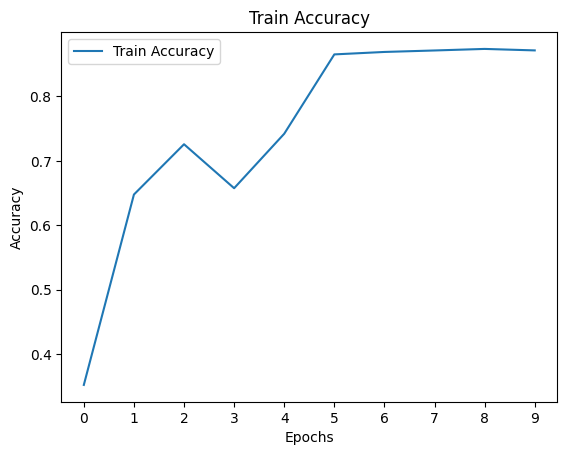

In [ ]:
# Draw the Fine-tuning result graph
import matplotlib.pyplot as plt
x_ticks = list(range(0, len(train_accuracy)))
plt.plot(x_ticks, train_accuracy, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.legend()
plt.xticks(x_ticks)
plt.show()